#Training RNNs on cognitive tasks

In [ ]:
# # Uninstall the current Gym version
# !pip uninstall -y gym

# # Install Gym version 0.23.1
# !pip install gym==0.23.1

# # Restart the runtime after installation (necessary in some environments like Colab)
# import os
# os._exit(00)


### Installing and importing relevant packages

In [ ]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1489/1489), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 13187 (delta 1166), reused 1218 (delta 1098), pack-reused 11698 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 9.80 MiB/s, done.
Resolving deltas: 100% (9970/9970), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793131 sha256=0c0c5a084e3b2f598ada63ab4a9ca36b660e90dda96dd8060498a04c38b4df41
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existi

In [ ]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

## Defining a recurrent neural network

In [ ]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neuron at each time step
        hidden_size: Number of hidden neurons (units) in the RNN
        dt: discretization time step in ms.
            If None, dt equals time constant tau.

            The new activity uses 1-alpha which determines how much of the old
            activity is remembered in the new time point, and it uses alpha to
            determine the update. This gives this model its leaky nature, that
            allows some previous information to decay over time.
            Alpha is dt/tau.

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.size(1))

        # Loop through time
        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

Let's determine the dimensions of its inputs and outputs.

In [ ]:
batch_size = 16
seq_len = 20  # sequence length
input_size = 5  # input dimension

# Make some random inputs
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Make network of 100 hidden units and 10 output units
rnn = RNNNet(input_size=input_size, hidden_size=100, output_size=10)

# Run the sequence through the network
out, rnn_output = rnn(input_rnn)

print('Input of shape =', input_rnn.shape)
print('Output of shape =', out.shape)

Input of shape = torch.Size([20, 16, 5])
Output of shape = torch.Size([20, 16, 10])


## Defining a simple cognitive task

Here we use the neurogym package to make a simple "perceptual decision making Delay Response" task. Let us install the package first. NeuroGym is a curated collection of neuroscience tasks with a common interface.

The code provided below defines a custom environment, PerceptualDecisionMakingDelayResponse, using neurogym. In this task an agent have to integrate two stimuli and report which one is larger on average after a delay.

In [ ]:
# @title importing neurogym
import neurogym as ngym

# Canned environment from neurogym

task_name = 'PerceptualDecisionMakingDelayResponse-v0'
# @title importing neurogym
import neurogym as ngym

# Canned environment from neurogym

task_name = 'PerceptualDecisionMakingDelayResponse-v0'
timing= {
     'fixation': ('choice', (50, 100, 200, 400)),
     'stimulus': ('choice', (100, 200, 400, 800)),
     'delay': ('choice', (100, 200, 400, 800)),
     }


# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing':timing}




/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


For **supervised learning**, we need a dataset that returns (input, target output pairs).

In [ ]:
# Make supervised dataset
seq_len = 100
batch_size = 16
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, batch_size=batch_size, seq_len=seq_len)
env = dataset.env

# Generate one batch of data when called
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)
print(target[:, 0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Input has shape (SeqLen, Batch, Dim) = torch.Size([100, 16, 3])
Target has shape (SeqLen, Batch) = (100, 16)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Network Training

Let's now train the network to perform the task.

RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.7738, Time 6.7s
Step 200, Loss 0.5877, Time 10.4s
Step 300, Loss 0.5420, Time 14.6s
Step 400, Loss 0.5193, Time 18.3s
Step 500, Loss 0.5039, Time 21.7s
Step 600, Loss 0.4906, Time 25.4s
Step 700, Loss 0.4882, Time 29.6s
Step 800, Loss 0.4772, Time 33.1s
Step 900, Loss 0.4679, Time 36.6s
Step 1000, Loss 0.4642, Time 41.0s
Step 1100, Loss 0.4516, Time 44.5s
Step 1200, Loss 0.4362, Time 48.0s
Step 1300, Loss 0.4242, Time 51.9s
Step 1400, Loss 0.4415, Time 55.8s
Step 1500, Loss 0.4206, Time 59.3s
Step 1600, Loss 0.4183, Time 63.5s
Step 1700, Loss 0.4155, Time 68.1s
Step 1800, Loss 0.3947, Time 71.7s
Step 1900, Loss 0.3967, Time 75.2s
Step 2000, Loss 0.3869, Time 79.7s
Step 2100, Loss 0.3796, Time 83.2s
Step 2200, Loss 0.3817, Time 86.7

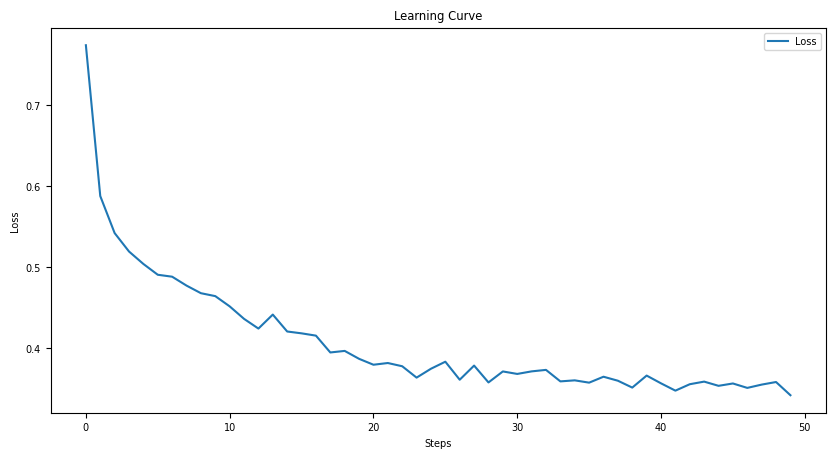

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
# Instantiate the network and print information
hidden_size = 128
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

def train_model(net, dataset):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss()

    loss_values = []  # List to store loss values
    running_loss = 0
    running_acc = 0
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(5000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            loss_values.append(running_loss)  # Append loss here
            running_loss = 0
    return net, loss_values

net, loss_values = train_model(net, dataset)

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.6820, Time 3.6s
Step 200, Loss 0.5382, Time 7.1s
Step 300, Loss 0.4983, Time 11.4s
Step 400, Loss 0.4824, Time 15.2s
Step 500, Loss 0.4705, Time 18.6s
Step 600, Loss 0.4573, Time 22.2s
Step 700, Loss 0.4508, Time 26.6s
Step 800, Loss 0.4449, Time 30.1s
Step 900, Loss 0.4396, Time 33.6s
Step 1000, Loss 0.4329, Time 38.0s
Step 1100, Loss 0.4345, Time 41.5s
Step 1200, Loss 0.4385, Time 45.0s
Step 1300, Loss 0.4059, Time 49.1s
Step 1400, Loss 0.4121, Time 52.9s
Step 1500, Loss 0.3831, Time 56.4s
Step 1600, Loss 0.3768, Time 60.0s
Step 1700, Loss 0.3751, Time 64.4s
Step 1800, Loss 0.3975, Time 67.9s
Step 1900, Loss 0.4206, Time 71.4s
Step 2000, Loss 0.3757, Time 75.8s
Step 2100, Loss 0.3721, Time 79.3s
Step 2200, Loss 0.3737, Time 82.7s

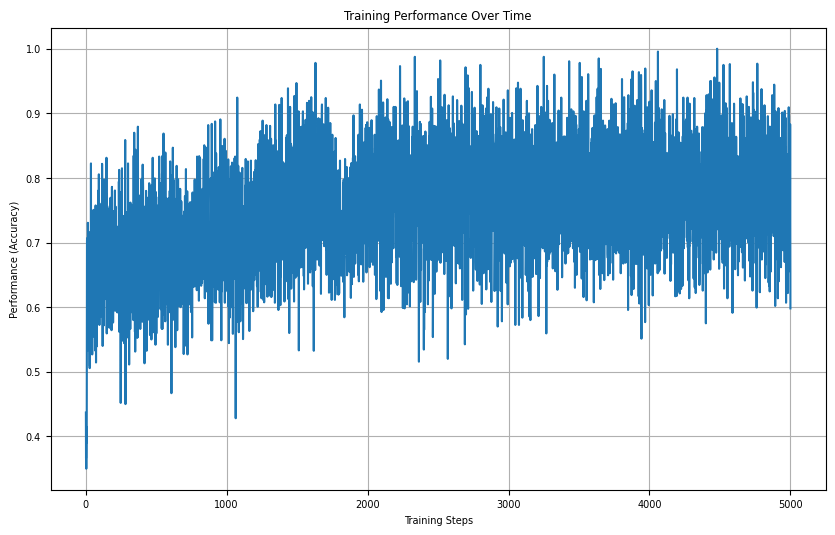

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import time
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import matplotlib.pyplot as plt

# Assuming the RNNNet class and other parts are defined as before.

def train_model(net, dataset):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
        performance: List of performance values at each step
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    performance = []  # To store performance at each step (accuracy)
    start_time = time.time()

    # Loop over training batches
    print('Training network...')
    for i in range(5000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        output, _ = net(inputs)

        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)

        # Compute loss
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()  # Updates the weights

        # Compute running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print(f'Step {i+1}, Loss {running_loss:.4f}, Time {time.time() - start_time:.1f}s')
            running_loss = 0

        # Compute accuracy for current batch (every step)
        with torch.no_grad():
            # Get predicted labels
            _, predicted = torch.max(output, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)

        # Store accuracy at this step
        performance.append(accuracy)

    return net, performance

# Instantiate the network
hidden_size = 128
net = RNNNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=env.dt)
print(net)

# Train the model and track performance
net, performance = train_model(net, dataset)

# Plot performance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 5001), performance)  # X-axis: steps, Y-axis: performance (accuracy)
plt.xlabel('Training Steps')
plt.ylabel('Performance (Accuracy)')
plt.title('Training Performance Over Time')
plt.grid(True)
plt.show()


## Testing the network

Here we run the network after training, record activity, and compute performance. We will explicitly loop through individual trials, so we can log the information and compute the performance of each trial.

In [ ]:
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information


num_trial = 200
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]


    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = trial_info  # trial_info is a dictionary
    trial_infos[i].update({'correct': correct})


# Print information for sample trials
for i in range(10):
    print('Trial ', i, trial_infos[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))



Trial  0 {'ground_truth': 1, 'coh': 6.4, 'sigma': 0.22360679774997896, 'correct': True}
Trial  1 {'ground_truth': 2, 'coh': 0.0, 'sigma': 0.22360679774997896, 'correct': False}
Trial  2 {'ground_truth': 2, 'coh': 0.0, 'sigma': 0.22360679774997896, 'correct': False}
Trial  3 {'ground_truth': 1, 'coh': 0.0, 'sigma': 0.22360679774997896, 'correct': True}
Trial  4 {'ground_truth': 2, 'coh': 25.6, 'sigma': 0.22360679774997896, 'correct': True}
Trial  5 {'ground_truth': 2, 'coh': 12.8, 'sigma': 0.22360679774997896, 'correct': True}
Trial  6 {'ground_truth': 1, 'coh': 12.8, 'sigma': 0.22360679774997896, 'correct': True}
Trial  7 {'ground_truth': 1, 'coh': 12.8, 'sigma': 0.22360679774997896, 'correct': True}
Trial  8 {'ground_truth': 2, 'coh': 12.8, 'sigma': 0.22360679774997896, 'correct': True}
Trial  9 {'ground_truth': 1, 'coh': 0.0, 'sigma': 0.22360679774997896, 'correct': True}
Average performance 0.825


# Plot the network's activity in PCA
Next we will analyze the network by plotting its activity in PCA space. Each trajectory in the PC-space would correspond to a single trial.

In [ ]:
# Apply PCA, boilerplate sklearn
from sklearn.decomposition import PCA

# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

pca = PCA(n_components=2)
pca.fit(activity)  # activity (Time points, Neurons)
activity_pc = pca.transform(activity)  # transform to low-dimension
print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

Shape of the neural activity: (Time points, Neurons):  (24421, 128)
Shape of the projected activity: (Time points, PCs):  (24421, 2)


Text(0, 0.5, 'PC 2')

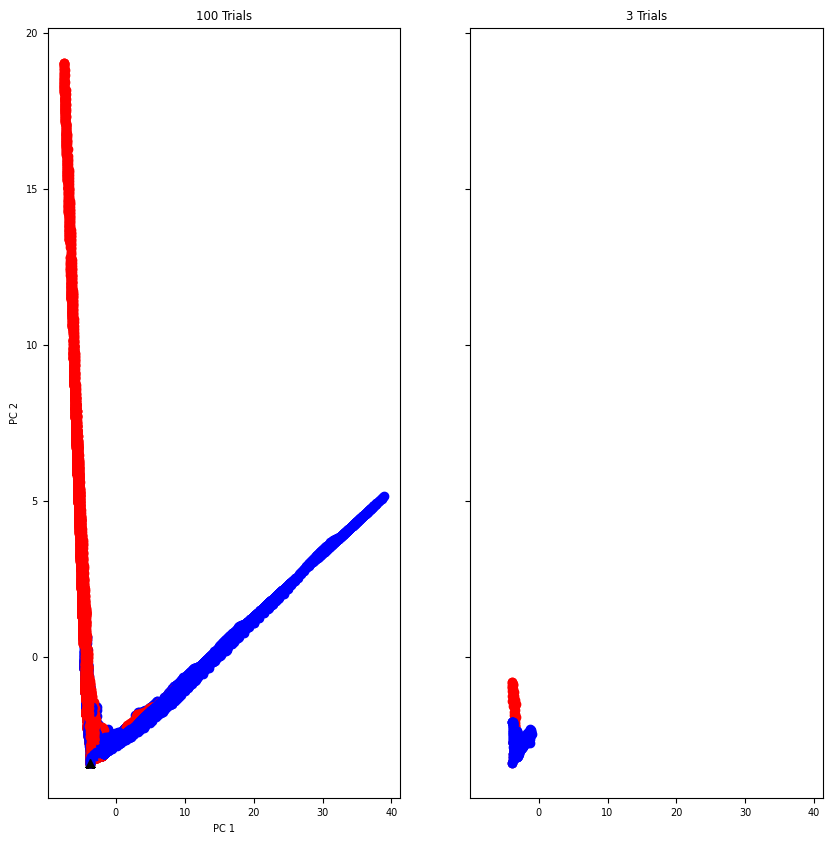

In [ ]:
# Project each trial and visualize activity

import matplotlib.pyplot as plt


# Plot all trials in ax1, plot fewer trials in ax2
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 10))

for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # (Time points, PCs)

    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'

    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 3:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

    # Plot the beginning of a trial with a special symbol
    _ = ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

ax1.set_title('{:d} Trials'.format(100))
ax2.set_title('{:d} Trials'.format(3))
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

# Plot neural activity from sample trials

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Activity')

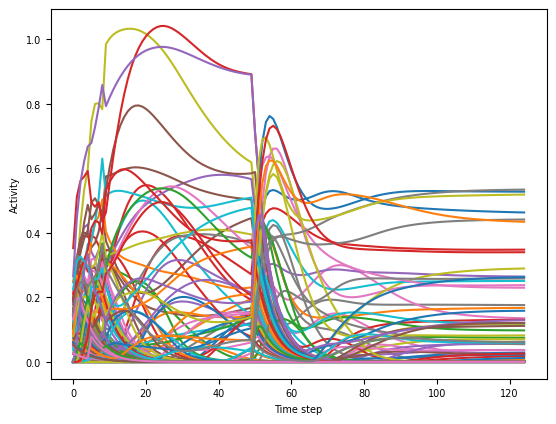

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial])

plt.xlabel('Time step')
plt.ylabel('Activity')